# CIFAR10 Image Classifier:

Following <a href="https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py">this guide</a>.


#### Dependencies:

In [71]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import time

#### Fetching and preprocessing the CIFAR10 dataset:

Functions for loading common datasets like the MNIST handwritten digits and CIFAR10 are provided under `torchvision.datasets`.

In [4]:
# The output of torchvision datasets are PILImage images. 
# Transform them to normalised tensors in range [-1, 1]: 
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

print("===== Preparing training dataset =====")
# Downloading CIFAR10 dataset and applying the normalised tensor transformation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Loading multiple samples concurrently:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

print("===== Preparing testing dataset =====")
# Downloading the testing set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# All output classes:
classes = (
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)

===== Preparing training dataset =====
Files already downloaded and verified
===== Preparing testing dataset =====
Files already downloaded and verified


#### Sample Images:
Showing some sample images from the dataset:

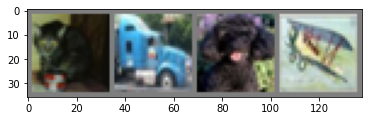

cat | truck | dog | plane


In [10]:
def imshow(img):
    img = img / 2 + 0.5   # Undoing the normalisation (converting range [-1, 1] to [0, 1])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Getting a random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Showing images:
imshow(torchvision.utils.make_grid(images))
print(" | ".join("{}".format(classes[labels[j]]) for j in range(4)))

#### Defining the Convolutional Network:

In [83]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


#### Training the Network:

In [84]:
elapsed_time = 0
for epoch in range(2):
    running_loss = 0.0
    epoch_start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimiser.zero_grad()
        outputs = net(inputs)             # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                   # Backpropagation
        optimiser.step()                  # Updating weights
 
        running_loss += loss.item()
    
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print("epoch %d: i=%5d | loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    epoch_end_time = time.time()
    elapsed_time += epoch_end_time - epoch_start_time
    print("Epoch training time: {} secs".format(epoch_end_time - epoch_start_time))

print("Finished training in {} secs".format(elapsed_time))

epoch 1: i= 2000 | loss: 2.180
epoch 1: i= 4000 | loss: 1.841
epoch 1: i= 6000 | loss: 1.646
epoch 1: i= 8000 | loss: 1.559
epoch 1: i=10000 | loss: 1.498
epoch 1: i=12000 | loss: 1.434
Epoch training time: 109.39096474647522 secs
epoch 2: i= 2000 | loss: 1.358
epoch 2: i= 4000 | loss: 1.323
epoch 2: i= 6000 | loss: 1.286
epoch 2: i= 8000 | loss: 1.266
epoch 2: i=10000 | loss: 1.247
epoch 2: i=12000 | loss: 1.205
Epoch training time: 71.62686443328857 secs
Finished training in 181.0178291797638 secs


### Testing the Network:

#### Testing a small sample:

       |===== Sample testing images =====|        


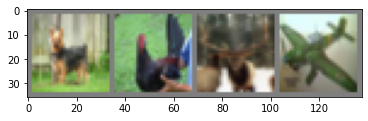

True classes:  dog | bird | deer | plane
Predicted:     deer | frog | deer | horse


       |===== Sample testing images =====|        


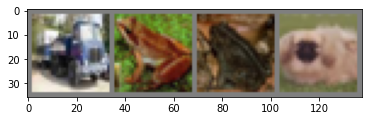

True classes:  truck | frog | frog | dog
Predicted:     truck | frog | cat | bird


       |===== Sample testing images =====|        


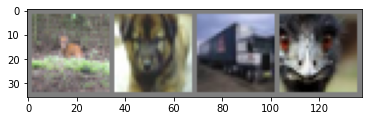

True classes:  deer | dog | truck | bird
Predicted:     bird | cat | truck | cat




In [85]:
dataiter = iter(testloader)

for i in range(random.randint(0, 20)):
    dataiter.next() 

# Showing 3 sample batches
for i in range(3):
    images, labels = dataiter.next()

    print("|===== Sample testing images =====|".center(50))
    imshow(torchvision.utils.make_grid(images))
    print("True classes: ", " | ".join("{}".format(classes[labels[j]]) for j in range(4)))
    
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    print("Predicted:    ", " | ".join("{}".format(classes[predicted[j]]) for j in range(4)))
    print("\n")

#### Testing the entire testing set:



In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d%%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [59]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d%%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 54 %
Accuracy of  bird : 36 %
Accuracy of   cat : 54 %
Accuracy of  deer : 45 %
Accuracy of   dog : 40 %
Accuracy of  frog : 69 %
Accuracy of horse : 73 %
Accuracy of  ship : 55 %
Accuracy of truck : 80 %


#### Saving the model:

In [18]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)